# <a id='toc1_'></a>[CQF - Final Project - Optimal Hedging with Advanced Greeks](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [CQF - Final Project - Optimal Hedging with Advanced Greeks](#toc1_)    
  - [Imports](#toc1_1_)    
  - [Monte Carlo for Geometric Brownian Motion](#toc1_2_)    
    - [Euler-Maruyama method](#toc1_2_1_)    
    - [Milstein method](#toc1_2_2_)    
    - [Exact solution](#toc1_2_3_)    
    - [Methods Comparison](#toc1_2_4_)    
  - [Monte Carlo improvements with Variance Reduction techniques](#toc1_3_)    
      - [Antithetic Variables](#toc1_3_1_1_)    
      - [Quasi-MonteCarlo using Sobol low-discrepancy sequence](#toc1_3_1_2_)    
      - [Brownian Bridge](#toc1_3_1_3_)    
  - [Portfolio P&L Study](#toc1_4_)    
  - [Minimum Variance Delta](#toc1_5_)    
      - [Load option data](#toc1_5_1_1_)    
  - [Local Volatility vs Implied Volatility](#toc1_6_)    
  - [References](#toc1_7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Imports](#toc0_)

In [289]:
import pandas as pd
import numpy as np
import math
import random
from itertools import accumulate
from scipy.stats import norm
from statistics import mean
from scipy.stats.mstats import gmean
from scipy.stats import qmc
import scipy.stats as scs
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

## <a id='toc1_2_'></a>[Monte Carlo for Geometric Brownian Motion](#toc0_)

In order to generate equity prices paths we will use Monte-Carlo through the Geometric Brownian Motion (GBM). This means that the stock price follows a random walk and is consistent with the weak form of the efficient market hypothesis (EMH) - past price information is already incorporated, and the next price movement is "conditionally independent" of past price movements.

A stochastic process $S_t$ is said to follow a GBM if it satisfies the following stochastic differential equation (SDE):

$$
dS_t = r S_t dt + \sigma S_t dW_t
$$

where:

$$
\begin{align*}
S &= \text{the stock price} \\
W_t &= \text{is a Wiener process or Brownian motion} \\
r &= \text{the drift or expected return} \\
\sigma &= \text{the volatility of returns} \\
\end{align*}
$$

In order to solve the SDE above, we can use a method to approximate numerical solution. We will discuss briefly and implement two of the most used schemes and compare them with the exact SDE solution.

### <a id='toc1_2_1_'></a>[Euler-Maruyama method](#toc0_)

The Euler-Maruyama is a method for the approximate numerical solution of a stochastic differential equation (SDE).

$$
S_{n+1} = S_{n} + S_{n}r\Delta t + S_{n}\sigma \Delta B(t) \sqrt{\Delta t}
$$

where:
$$
\begin{align*}
S_0 &= \alpha \\
\end{align*}
$$

In [138]:
def euler_maruyama_scheme(S0, r, dt, sigma, B):
    """ the function returns the asset price evolution according to euler-maruyama scheme
    
    Keyword arguments:
    S0 -- the price of equity on time t0
    r -- the expected return
    dt -- the slice of time
    sigma -- the standard deviation of returns
    dB -- an array of random variables according to wiener process
    """
    return list(accumulate(B, lambda S,db: S + r*S*dt + sigma*S*db*np.sqrt(dt), initial=S0))

Text(0.5, 0, 'time')

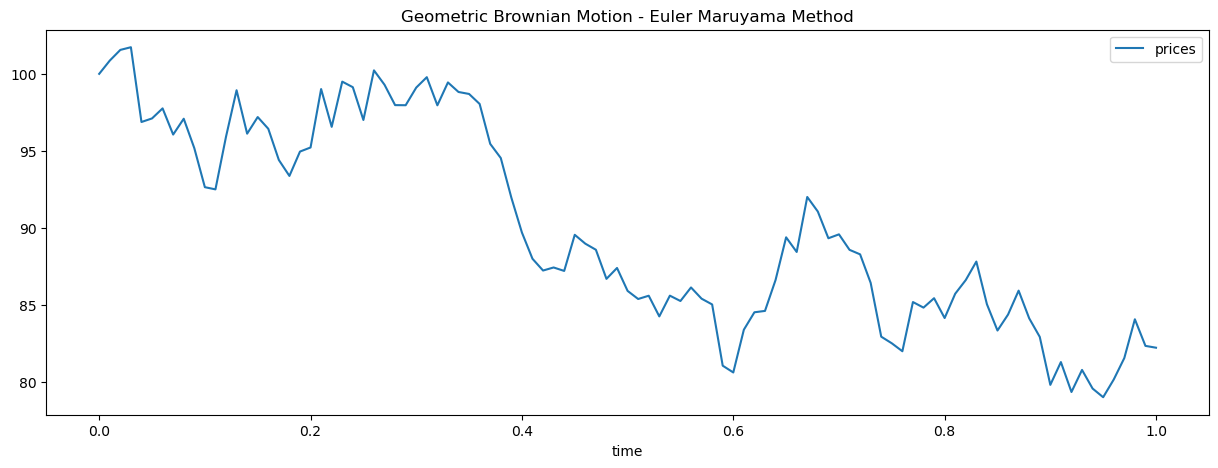

In [167]:
S0 = 100.0 # asset initial price
T = 1.0 # option expiry
sigma = 0.2 # volatility
r = 0.05 # drift
N = 100 # number of discretization steps
dt = T / N
B = np.random.randn(N) # wiener process

S = euler_maruyama_scheme(S0, r, dt, sigma, B)
df = pd.DataFrame(index=np.arange(0, T+dt, dt), data=S, columns=['prices'])
ax = df.plot(colormap='tab10', figsize=[15,5], title='Geometric Brownian Motion - Euler Maruyama Method');
ax.set_xlabel('time')

### <a id='toc1_2_2_'></a>[Milstein method](#toc0_)

The Milstein scheme is obtained by using the second order stochastic Taylor expansion, after rewriting it in Itô form

$$
S_{n+1} = S_{n} + rS_{n}\Delta t + \sigma S_{n}\Delta B(t) \sqrt{\Delta t} + \frac{1}{2}\sigma^{2} S_{n} ((\Delta B(t) \sqrt{\Delta t})^{2} - \Delta t)
$$

In [140]:
def milstein_scheme(S0, r, dt, sigma, B):
    """ the function returns the asset price evolution according to milstein scheme
    
    Keyword arguments:
    S0 -- the price of equity on time t0
    r -- the expected return
    dt -- the slice of time
    sigma -- the standard deviation of returns
    dB -- an array of random variables according to wiener process
    """
    return list(accumulate(B, lambda S,db: S + r*S*dt + sigma*S*db*np.sqrt(dt) + 0.5*(sigma**2)*S*((db*np.sqrt(dt))**2-dt), initial=S0))

Text(0.5, 0, 'time')

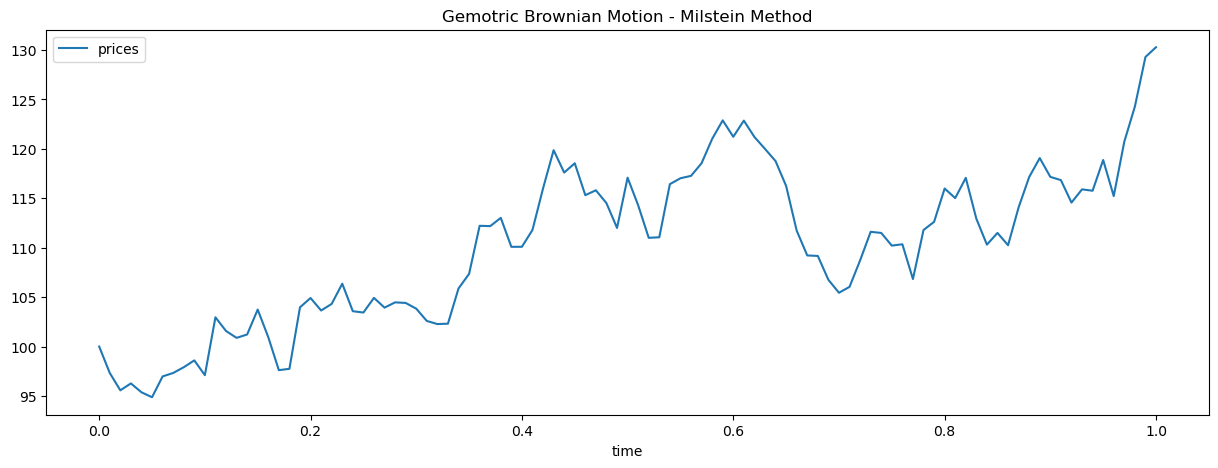

In [164]:
S0 = 100.0
T = 1.0
sigma = 0.2
r = 0.05
N = 100
dt = T / N
B = np.random.randn(N)

S = milstein_scheme(S0, r, dt, sigma, B)
df = pd.DataFrame(index=np.arange(0, T+dt, dt), data=S, columns=['prices'])
ax = df.plot(colormap='tab10', figsize=[15,5], title='Gemotric Brownian Motion - Milstein Method');
ax.set_xlabel('time')

### <a id='toc1_2_3_'></a>[Exact solution](#toc0_)

$$
S_{n+1} = S_{n}\exp{((r-\frac{\sigma^2}{2})t + \sigma B(t) \sqrt{\Delta t})}
$$m

In [142]:
def closed_form_scheme(S0, r, dt, sigma, B):
    """ the function returns the asset price evolution according to milstein scheme
    
    Keyword arguments:
    S0 -- the price of equity on time t0
    r -- the expected return
    dt -- the slice of time
    sigma -- the standard deviation of returns
    dB -- an array of random variables according to wiener process
    """
    return list(accumulate(B, lambda S,db: S * np.exp((r-0.5*sigma**2)*dt + sigma*db*np.sqrt(dt)), initial=S0))

Text(0.5, 0, 'time')

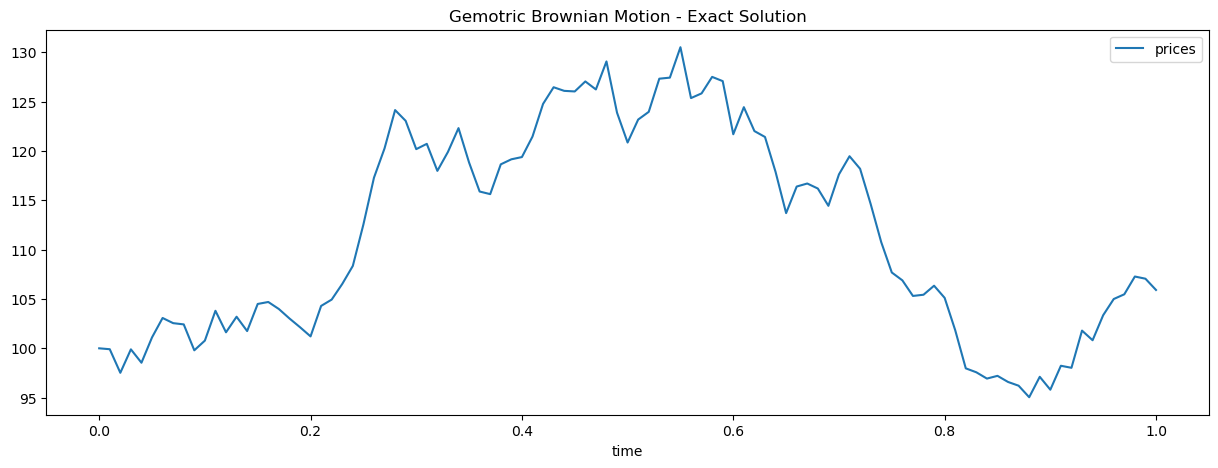

In [165]:
S0 = 100.0
T = 1.0
sigma = 0.2
r = 0.05
N = 100
dt = T / N
B = np.random.randn(N)

S = closed_form_scheme(S0, r, dt, sigma, B)
df = pd.DataFrame(index=np.arange(0, T+dt, dt), data=S, columns=['prices'])
ax = df.plot(colormap='tab10', figsize=[15,5], title='Gemotric Brownian Motion - Exact Solution');
ax.set_xlabel('time')

### <a id='toc1_2_4_'></a>[Methods Comparison](#toc0_)

Text(0.5, 0, 'time')

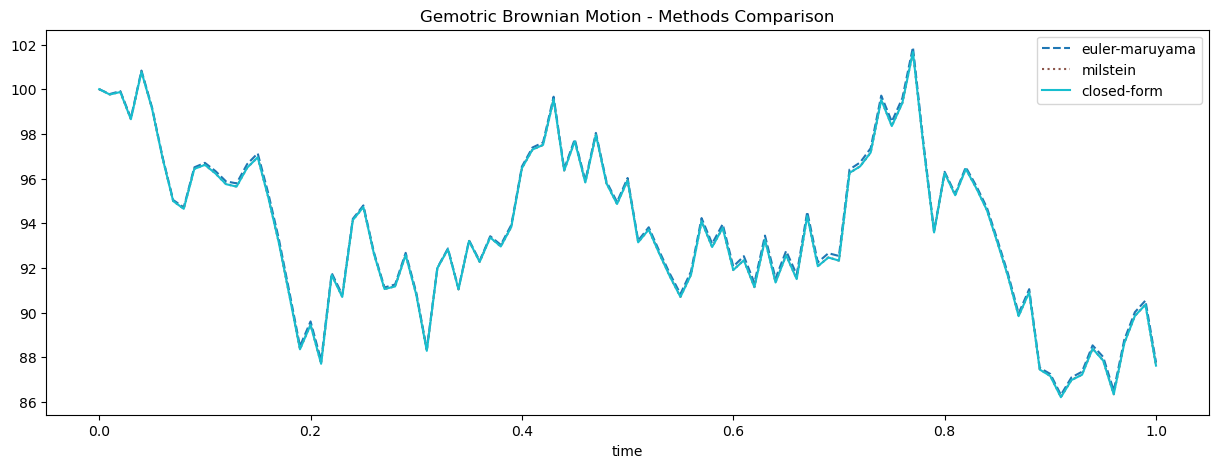

In [166]:
S0 = 100.0
T = 1.0
sigma = 0.2
r = 0.05
N = 100
dt = T / N
B = np.random.randn(N)

df_schemes = pd.DataFrame(index=np.arange(0, T+dt, dt))
df_schemes['euler-maruyama'] = euler_maruyama_scheme(S0, r, dt, sigma, B)
df_schemes['milstein'] = milstein_scheme(S0, r, dt, sigma, B)
df_schemes['closed-form'] = closed_form_scheme(S0, r, dt, sigma, B)
ax = df_schemes.plot(style=['--', ':', '-'],colormap='tab10', figsize=[15,5], title='Gemotric Brownian Motion - Methods Comparison');
ax.set_xlabel('time')

Plot above shows that Milstein method gives us a better approximation to the close form solution. The Milstein method has an error of $O(\delta t^2)$ while Euler-Maruyama has an error of $O(\delta t)$.

## <a id='toc1_3_'></a>[Monte Carlo improvements with Variance Reduction techniques](#toc0_)

In order to improve our Monte Carlo simulations we will use some variance reduce techniques, that consist in a procedure to increase the precision of the estimates obtained for a given simulation or computational effort.

#### <a id='toc1_3_1_1_'></a>[Antithetic Variables](#toc0_)

The technique consists in simply, for every sample path obtained, take its antithetic path. Thus, given a path $\{b_1, b_2, ..., b_n\}$, we will also include its antithetic values $\{-b_1, -b_2, ..., -b_n\}$

The described method works for sysmmetric median 0 random variables only, like standard normally distributed random variables, which are almost exclusively used throughout. 

In order to get a realistic comparison we will fixed the seed value for random number generator 

In [173]:
print('%12s %15s %15s' % ('N Variables', 'Mean', 'Std. Deviation'))
print(47* '-')
for i in range(1, 31, 2):
    np.random.seed(100) # fixed seed for comparison purpose
    sn = np.random.standard_normal(i ** 2 * 10000)
    print('%12.f %15.12f %15.12f' % (i ** 2 * 10000, sn.mean(), sn.std()))

 N Variables            Mean  Std. Deviation
-----------------------------------------------
       10000  0.001150944833  1.006296354600
       90000  0.002841204001  0.995987967146
      250000  0.001998082016  0.997701714233
      490000  0.001322322067  0.997771186968
      810000  0.000592711311  0.998388962646
     1210000 -0.000339730751  0.998399891450
     1690000 -0.000228109010  0.998657429396
     2250000  0.000295768719  0.998877333340
     2890000  0.000257107789  0.999284894532
     3610000 -0.000357870642  0.999456401088
     4410000 -0.000528443742  0.999617831131
     5290000 -0.000300171536  0.999445228838
     6250000 -0.000162924037  0.999516059328
     7290000  0.000135778889  0.999611052522
     8410000  0.000182006048  0.999619405229


The result shows that the statistics get better the larger the sample size. However it does not still match.

In [175]:
print('%12s %15s %15s' % ('N Variables', 'Mean', 'Std. Deviation'))
print(47* '-')
for i in range(1, 31, 2):
    np.random.seed(100)
    sn = np.random.standard_normal(i ** 2 * int(10000 / 2))
    sn = np.concatenate((sn, -sn))
    print('%12.f %15.12f %15.12f' % (i ** 2 * 10000, sn.mean(), sn.std()))

 N Variables            Mean  Std. Deviation
-----------------------------------------------
       10000 -0.000000000000  1.017474904235
       90000  0.000000000000  0.998944776883
      250000  0.000000000000  0.998018870658
      490000  0.000000000000  0.997916558845
      810000 -0.000000000000  0.998119811838
     1210000  0.000000000000  0.998365584578
     1690000  0.000000000000  0.998171301115
     2250000 -0.000000000000  0.998359568664
     2890000 -0.000000000000  0.998772594780
     3610000 -0.000000000000  0.998640403762
     4410000  0.000000000000  0.998868127277
     5290000  0.000000000000  0.999102053335
     6250000  0.000000000000  0.999342143561
     7290000  0.000000000000  0.999449673443
     8410000 -0.000000000000  0.999613960655


This results in a mean value of zero and a reduction in standard deviation, even in smaller sample sizes.

#### <a id='toc1_3_1_2_'></a>[Quasi-MonteCarlo using Sobol low-discrepancy sequence](#toc0_)

Quasi-Monte Carlo simulation is the traditional Monte Carlo simulation but using **quasi-random sequences** instead (pseudo) random numbers. These sequences are known as **low-discrepancy sequences** and they are **totally deterministic**, used in several cases to improve the performance of Monte Carlo simulations, offering shorter computational times and/or higher accuracy.

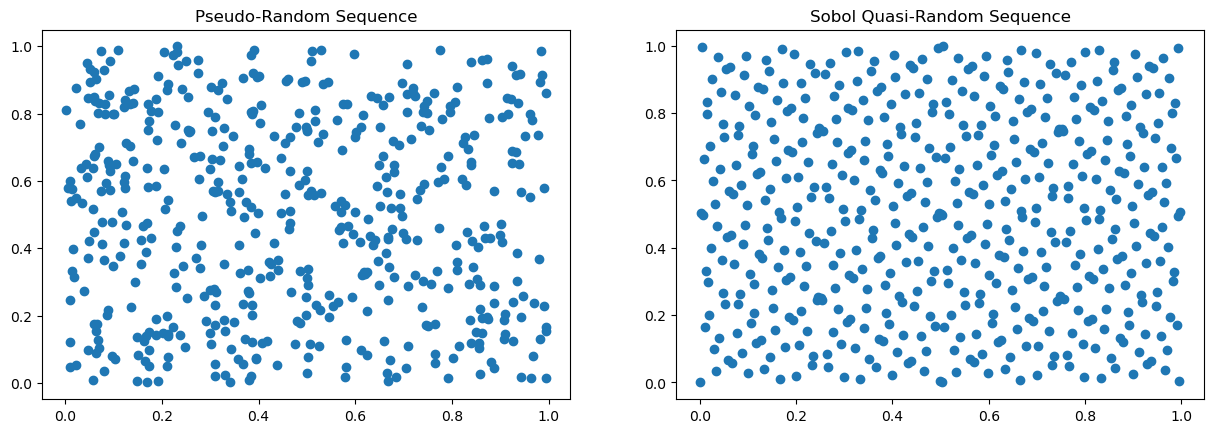

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)
ax1.set_title('Pseudo-Random Sequence')
ax1.scatter(x=np.random.rand(2**9), y=np.random.rand(2**9))
sampler = qmc.Sobol(d=2, scramble=False)
sample_sequence = sampler.random_base2(m=9)
ax2.set_title('Sobol Quasi-Random Sequence')
ax2.scatter(x=sample_sequence[:,0], y=sample_sequence[:,1]);

From the figure above we can see that the quasi random sequence the draw points are more homegenous than pseudo random. While in pseudo-random sequence, it is possible to observe some small empty clusters. 

#### <a id='toc1_3_1_3_'></a>[Brownian Bridge](#toc0_)

A Brownian bridge is acontinuous-time stochastic process $B(t)$ whose probability distribution is the conditional provability distribution of a Wiener process $W(t)$ subject to the condition (when standardized) that $W(T) = 0$. More precisely:

$$
B_t := (W_t|W_T = 0), t \in [0,T]
$$

Generally, a Brownian bridge can be defined as:

Suppose: $\{ W_t \}_{t \in [0,T]}$ is an 1-dimenstional Brownian motion, $a,b \in \mathbb{R}$, then the process

$$
B_t^{a,b} = a \frac{T-t}{T} + b \frac{t}{T} + \left( W_t - \frac{t}{T}W_T \right), t \in [0,T]
$$

is a Browninan bridge from $a$ to $b$

Is satisfies

$$
B_t^{a,b} \sim \mathcal{N}\left( a + \frac{t}{T}(b-a), t-\frac{t^2}{T} \right)
$$

where $\mathcal{N}$ is normal provability distribution 

The algorithm idea is to generate a random jump from a point $x_0$ at time 0 toa apiont $x_T$ at time $T$ and this can be expressed as

$$
x_T = x_0 + \sqrt{T}Z_t
$$

where $Z$ is a standard Brownian motion.

Now, given the point $x_0$ and the final point $x_T$, the Brownian bridge algorithm provides the formula for an intermediate point $x_t$

$$
x_t = (1-\gamma_t)x_0 + \gamma_t x_T + \sqrt{\gamma_t (1-\gamma_t)T}Z_t
$$

where $\gamma_t = \frac{t}{T}$

Once $x_t$ has been determined, formula above can be used for the subintervals $(0,t)$ and $(t,T)$. The recursive implementation of the algorithm procues a random path connecting $x_0$ and $x_T$



This algorithm implements brownian bridge with length $N=2^K$ 

DescribeResult(nobs=256, minmax=(-3.24433957150059, 2.71611568385884), mean=-0.0013509235440951617, variance=1.004244221816148, skewness=-0.03762469690301749, kurtosis=-0.0034524850888875136)

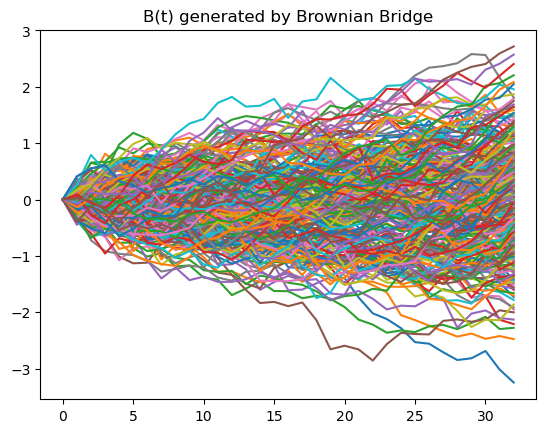

In [176]:
def brownian_bridge(m, k, T):
    """ the function returns a brownian motion with 2**m paths and 2**k discretization steps in time time T
    
    Keyword arguments:
    m -- number of paths in the form 2**m
    k -- number of steps in the form 2**k
    T -- the time to expiry
    """
    n = 2**k
    dt = T / n
    t = np.arange(0, T+dt, dt)
    total_paths = 2**m

    sampler = qmc.Sobol(d=1, scramble=True)
    qunif = np.array(sampler.random_base2(m=m))[:, 0]
    qunif = (qunif + range(0,total_paths))/total_paths

    W = np.zeros((total_paths,n+1))
    W[:,-1] = norm.ppf(qunif)*np.sqrt(t[-1])
    Z = np.random.standard_normal((total_paths, n-1))
    
    for i in range(0, k):
        h = 2**(k-i)
        for j in range(0, 2**i):
            a = j*h
            b = j*h+int(h/2)
            c = (j+1)*h
            lw = (t[c]-t[b])/(t[c]-t[a])
            rw = (t[b]-t[a])/(t[c]-t[a])
            stdev = ((t[c]-t[b])*(t[b]-t[a]))/(t[c]-t[a])
            W[:, b] = lw*W[:, a] + rw*W[:, c] + np.sqrt(stdev)*Z[:, b-1]
    return W

m = 8
k = 5
T = 1
Ws = brownian_bridge(m, k, T)

plt.title('B(t) generated by Brownian Bridge')
for w in Ws:
    plt.plot(w);

scs.describe(np.array(Ws)[:, -1])

We will use Black Sholes Merton to implement functions to calculate the value of a call and their greeks, in orde to compare each variance reduction techniques 

Text(0, 0.5, '|error|')

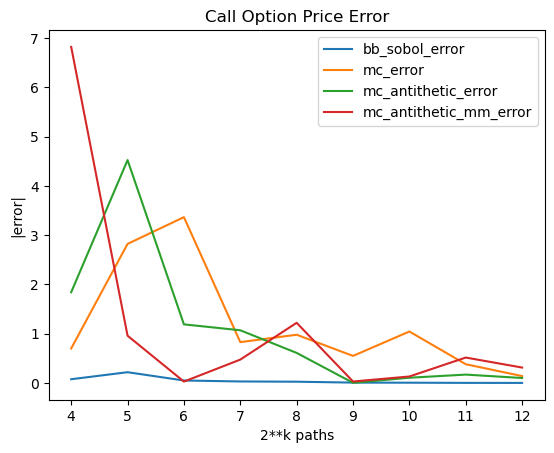

In [187]:
def BlackScholesMerton(S0, K, r, div, sigma, T):
    h1 = (np.log(S0 / K) + ((r - div) + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    h2 = h1 - sigma * np.sqrt(T)
    return S0 * np.exp(-div * T) * norm.cdf(h1) - K * np.exp(-r * T) * norm.cdf(h2)

def price_with_brownian_bridge(m):
    k = 0
    T = 1
    B = brownian_bridge(m, k, T)
    t = np.arange(0, T+T/2**k, T/2**k)
    paths = S0 * np.exp((r-0.5*sigma**2)*t + sigma*B)
    return np.exp(-r*T)*np.mean(np.maximum(paths[:, -1] - K, 0))

def pricing_with_mc(m):
    z = np.random.standard_normal(2**m)
    S = S0 * np.exp((r-0.5*sigma**2)*T + sigma*z*np.sqrt(T))
    return np.exp(-r*T)*np.mean(np.maximum(S - K, 0))

def pricing_with_mc_antithetic(m):
    z = np.random.standard_normal(2**(m-1))
    z = np.concatenate((z,-z))
    S = S0 * np.exp((r-0.5*sigma**2)*T + sigma*np.random.standard_normal(2**m)*np.sqrt(T))
    return np.exp(-r*T)*np.mean(np.maximum(S - K, 0))

def pricing_with_mc_antithetic_mm(m):
    z = np.random.standard_normal(2**(m-1))
    z = np.concatenate((z,-z))
    z = (z-z.mean())/z.std()
    S = S0 * np.exp((r-0.5*sigma**2)*T + sigma*np.random.standard_normal(2**m)*np.sqrt(T))
    return np.exp(-r*T)*np.mean(np.maximum(S - K, 0))

S0 = 100.0 # pot at time zero
K = 100.0 # option strike
T = 1.0 # time to expiry
r = 0.05 # risk free rate
div = 0.00 # dividend yield
sigma = 0.2 # volatility

df = pd.DataFrame(data=list(range(4, 13)), columns=['m_paths'])
df['exact'] = BlackScholesMerton(S0=S0, K=K, r=r, div=div, sigma=sigma, T=T)
df['bb_sobol'] = df.m_paths.apply(lambda m: price_with_brownian_bridge(m))
df['mc'] = df.m_paths.apply(lambda m: pricing_with_mc(m))
df['mc_antithetic'] = df.m_paths.apply(lambda m: pricing_with_mc_antithetic(m))
df['mc_antithetic_mm'] = df.m_paths.apply(lambda m: pricing_with_mc_antithetic_mm(m))

methods = ['bb_sobol', 'mc', 'mc_antithetic', 'mc_antithetic_mm']
methods_error = [method+'_error' for method in methods]

for m, m_err in zip(methods, methods_error):
    df[m_err] = abs(df[m] - df['exact'])

ax = df[['m_paths'] + methods_error].plot(x='m_paths', title='Call Option Price Error');
ax.set_xlabel('2**k paths');
ax.set_ylabel('|error|')

From the plot above, we can see that brownian bridge using sobol sequence minimizes the error and the convergence is still good even for a small number of paths. 

## <a id='toc1_4_'></a>[Portfolio P&L Study](#toc0_)

Let´s define the Black Scholes Merton function to calculate a call value and their greeks.

In [188]:
def get_asset_path(S0, r, dt, sigma, B):
    return list(accumulate(B, lambda S,db: S * np.exp((r-0.5*sigma**2)*dt + sigma*db*np.sqrt(dt)), initial=S0))

def get_d(S, sigma, div, r, K, dt):
    d1 = (np.log(S / K) + (r - div + 0.5 * sigma**2) * dt) / sigma / np.sqrt(dt)
    d2 = d1 - sigma * np.sqrt(dt)
    return d1, d2

def get_N(S, sigma, div, r, K, dt):
    d1, d2 = get_d(S, sigma, div, r, K, dt)
    return norm.cdf(d1), norm.cdf(d2)

def get_deltaN(d):
    return (1.0 / np.sqrt(2*np.pi))*np.exp(-d**2/2)

def get_call(S, sigma, div, r, K, dt):
    if dt == 0:
        return max(S-K, 0)

    N1, N2 = get_N(S, sigma, div, r, K, dt)
    return S * np.exp(-div * dt) * N1 - K * np.exp(-r * dt) * N2

def get_delta(S, sigma, div, r, K, dt):
    if dt == 0:
        return 1 if max(S-K, 0) > 0 else 0
    N1, N2 = get_N(S, sigma, div, r, K, dt)
    return np.exp(-div * dt) * N1

def get_gamma(S, sigma, div, r, K, dt):
    if dt == 0:
        return 0
    d1, d2 = get_d(S, sigma, div, r, K, dt)
    return np.exp(-div * dt) * get_deltaN(d1) / sigma / S / np.sqrt(dt)

def get_vega(S, sigma, div, r, K, dt):
    if dt == 0:
        return 0
    d1, d2 = get_d(S, sigma, div, r, K, dt)
    return S * np.sqrt(dt) * np.exp(-div * dt) * get_deltaN(d1)

Let´s also create the function responsible to calculate the portfolio P&L

In [198]:
def get_portfolio(S0, r, K, T, N, B, vol_local, vol_impl, repl_vol='implied'):
    dt = T/N
    df = pd.DataFrame(index=np.arange(0, T+dt, dt), data=np.arange(0, T+dt, dt), columns=['t'])
    df['S'] = get_asset_path(S0, r, dt, vol_local, B)
    df['S_return'] = df.S.pct_change()
    df['option'] = df.apply(lambda row: get_call(row.S, vol_impl, 0, r, K, T-row.t), axis=1)
    df['vol_local'] = vol_local
    df['vol_impl'] = vol_impl

    for vol_type in ['local', 'impl']:
        df['delta_' + vol_type] = df.apply(lambda row: get_delta(row.S, row['vol_' + vol_type], 0, r, K, T-row.t), axis=1)
        df['portfolio_' + vol_type] = df.option - df['delta_' + vol_type]*df.S
        df['cashflow_delta_' + vol_type] = (df['delta_' + vol_type] - df['delta_' + vol_type].shift(1)) * df.S
        df['cash_account_' + vol_type] = list(accumulate(df['cashflow_delta_' + vol_type].values[1:], lambda a,b: a * np.exp(r*dt) + b, initial=-df['portfolio_' + vol_type].values[0]))
        df['pl_cum_' + vol_type] = df['portfolio_' + vol_type] + df['cash_account_' + vol_type]
        
        df['gamma_' + vol_type] = df.apply(lambda row: get_gamma(row.S, row['vol_' + vol_type], 0, r, K, T-row.t), axis=1)
        df['pl_realized_implied_' + vol_type] = df.apply(lambda row: 0.5*row['gamma_' + vol_type]*row.S**2*(row.S_return**2-row['vol_' + vol_type]**2*dt), axis=1)
        df['made_money_' + vol_type] = df.apply(lambda row: row.S_return**2 >= row['vol_' + vol_type]**2*dt, axis=1)
        df['gamma_total_pl_' + vol_type] = df.apply(lambda row: row['pl_realized_implied_' + vol_type]*np.exp(-r*dt), axis=1)

        df['actual_pl_' + vol_type] = df.loc[T]['pl_cum_' + vol_type]*np.exp(-r*T)

    return df

def plot_portfolio(vol_type = 'local'):
    fig, ax = plt.subplots(3, 1, figsize=(15,12), gridspec_kw={'hspace': 0.4}) 
    
    ax[0].set_title('Asset/P&L evolution')
    portfolio.plot(x = 't', y = 'S', ax = ax[0]) 
    portfolio.plot(x = 't', y = 'pl_cum_' + vol_type, ax = ax[0], secondary_y = True) 
    
    ax[1].set_title('Asset/Gamma evolution')
    portfolio.plot(x = 't', y = 'S', ax = ax[1]) 
    portfolio.plot(x = 't', y = 'gamma_' + vol_type, ax = ax[1], secondary_y = True) 
    
    ax[2].set_title('Gamma/P&L implied - realized')
    portfolio.plot(x = 't', y = 'pl_realized_implied_' + vol_type, ax = ax[2]) 
    portfolio.plot(x = 't', y = 'gamma_' + vol_type, ax = ax[2], secondary_y = True);

Now, we will simulate the porfolio P&L under arbitrage condition where we know that the local volatility is greater than the implied volatility, thus:

$$
V_{local} > V_{implied}
$$

In [207]:
S0 = 100
r = 0.02
K = 100
T = 1
N = 200
vol_local = 0.35
vol_impl = 0.2
B = pd.read_csv('bs.csv').B.values # np.random.randn(N)

portfolio = get_portfolio(S0, r, K, T, N, B, vol_local, vol_impl)
portfolio.head()

,t,S,S_return,option,vol_local,vol_impl,delta_local,portfolio_local,cashflow_delta_local,cash_account_local,...,delta_impl,portfolio_impl,cashflow_delta_impl,cash_account_impl,pl_cum_impl,gamma_impl,pl_realized_implied_impl,made_money_impl,gamma_total_pl_impl,actual_pl_impl
0.000,0.000,100.000000,NaN,8.916037,0.35,0.2,0.591786,-50.262610,NaN,50.262610,...,0.579260,-49.009934,NaN,49.009934,0.000000,0.019552,NaN,False,NaN,4.725325
0.005,0.005,106.059131,0.060591,12.743657,0.35,0.2,0.655444,-56.772127,6.751426,57.019062,...,0.689478,-60.381748,11.689624,60.704459,0.322711,0.016686,0.325768,True,0.325735,4.725325
0.010,0.010,108.861339,0.026421,14.714747,0.35,0.2,0.682530,-59.586424,2.948697,59.973461,...,0.734231,-65.214625,4.871906,65.582436,0.367811,0.015142,0.044689,True,0.044685,4.725325
0.015,0.015,106.719151,-0.019678,13.152754,0.35,0.2,0.661882,-57.482767,-2.203542,57.775917,...,0.700595,-61.614164,-3.589593,61.999401,0.385238,0.016399,0.017484,True,0.017482,4.725325
0.020,0.020,107.102191,0.003589,13.397492,0.35,0.2,0.665615,-57.891376,0.399819,58.181515,...,0.706965,-62.319979,0.682198,62.687800,0.367820,0.016221,-0.017408,False,-0.017407,4.725325


Portfolio P&L study delta hedging with local volatility

In [208]:
portfolio[['S', 'option']+[col for col in portfolio.columns if col.endswith('_local')]]

,S,option,vol_local,delta_local,portfolio_local,cashflow_delta_local,cash_account_local,pl_cum_local,gamma_local,pl_realized_implied_local,made_money_local,gamma_total_pl_local,actual_pl_local
0.000,100.000000,8.916037,0.35,0.591786,-50.262610,NaN,50.262610,0.000000,1.109532e-02,NaN,False,NaN,5.985449
0.005,106.059131,12.743657,0.35,0.655444,-56.772127,6.751426,57.019062,0.246935,9.945543e-03,1.710987e-01,True,1.710816e-01,5.985449
0.010,108.861339,14.714747,0.35,0.682530,-59.586424,2.948697,59.973461,0.387037,9.401582e-03,4.767469e-03,True,4.766992e-03,5.985449
0.015,106.719151,13.152754,0.35,0.661882,-57.482767,-2.203542,57.775917,0.293150,9.863073e-03,-1.265237e-02,False,-1.265110e-02,5.985449
0.020,107.102191,13.397492,0.35,0.665615,-57.891376,0.399819,58.181515,0.290139,9.810313e-03,-3.373835e-02,False,-3.373497e-02,5.985449
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.980,159.692296,59.732288,0.35,1.000000,-99.960008,0.000000,106.063929,6.103921,1.409362e-21,-7.113298e-21,False,-7.112586e-21,5.985449
0.985,162.475552,62.505547,0.35,1.000000,-99.970004,0.000000,106.074536,6.104531,6.015127e-30,-2.451186e-29,False,-2.450941e-29,5.985449
0.990,162.783379,62.803377,0.35,1.000000,-99.980002,0.000000,106.085144,6.105142,4.171161e-44,-3.365120e-43,False,-3.364783e-43,5.985449
0.995,159.682702,59.692701,0.35,1.000000,-99.990000,0.000000,106.095753,6.105752,1.634353e-79,-5.202511e-79,False,-5.201991e-79,5.985449


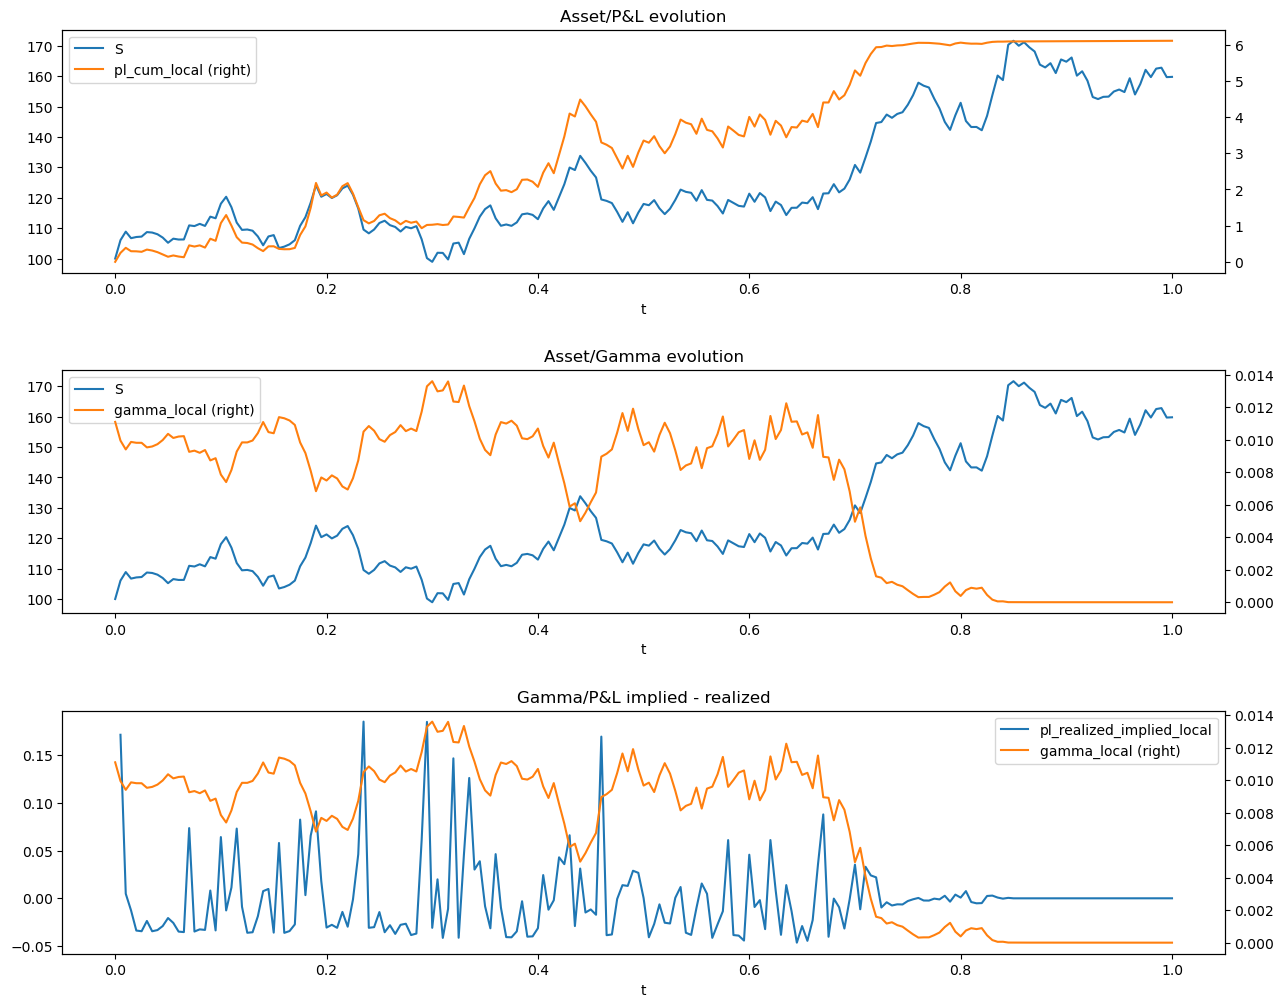

In [200]:
plot_portfolio('local')

Portfolio P&L study delta hedging with implied volatility

In [202]:
portfolio[['S', 'option']+[col for col in portfolio.columns if col.endswith('_impl')]]

,S,option,vol_impl,delta_impl,portfolio_impl,cashflow_delta_impl,cash_account_impl,pl_cum_impl,gamma_impl,pl_realized_implied_impl,made_money_impl,gamma_total_pl_impl,actual_pl_impl
0.000,100.000000,8.916037,0.2,0.579260,-49.009934,NaN,49.009934,0.000000,1.955213e-02,NaN,False,NaN,4.725325
0.005,106.059131,12.743657,0.2,0.689478,-60.381748,11.689624,60.704459,0.322711,1.668588e-02,3.257679e-01,True,3.257353e-01,4.725325
0.010,108.861339,14.714747,0.2,0.734231,-65.214625,4.871906,65.582436,0.367811,1.514211e-02,4.468918e-02,True,4.468471e-02,4.725325
0.015,106.719151,13.152754,0.2,0.700595,-61.614164,-3.589593,61.999401,0.385238,1.639889e-02,1.748408e-02,True,1.748233e-02,4.725325
0.020,107.102191,13.397492,0.2,0.706965,-62.319979,0.682198,62.687800,0.367820,1.622107e-02,-1.740846e-02,False,-1.740672e-02,4.725325
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.980,159.692296,59.732288,0.2,1.000000,-99.960008,0.000000,104.778863,4.818855,1.870997e-61,3.976538e-62,True,3.976140e-62,4.725325
0.985,162.475552,62.505547,0.2,1.000000,-99.970004,0.000000,104.789342,4.819337,3.418734e-87,4.682344e-87,True,4.681876e-87,4.725325
0.990,162.783379,62.803377,0.2,1.000000,-99.980002,0.000000,104.799821,4.819819,9.835091e-131,-2.559370e-130,False,-2.559115e-130,4.725325
0.995,159.682702,59.692701,0.2,1.000000,-99.990000,0.000000,104.810302,4.820301,1.669940e-239,3.466554e-239,True,3.466207e-239,4.725325


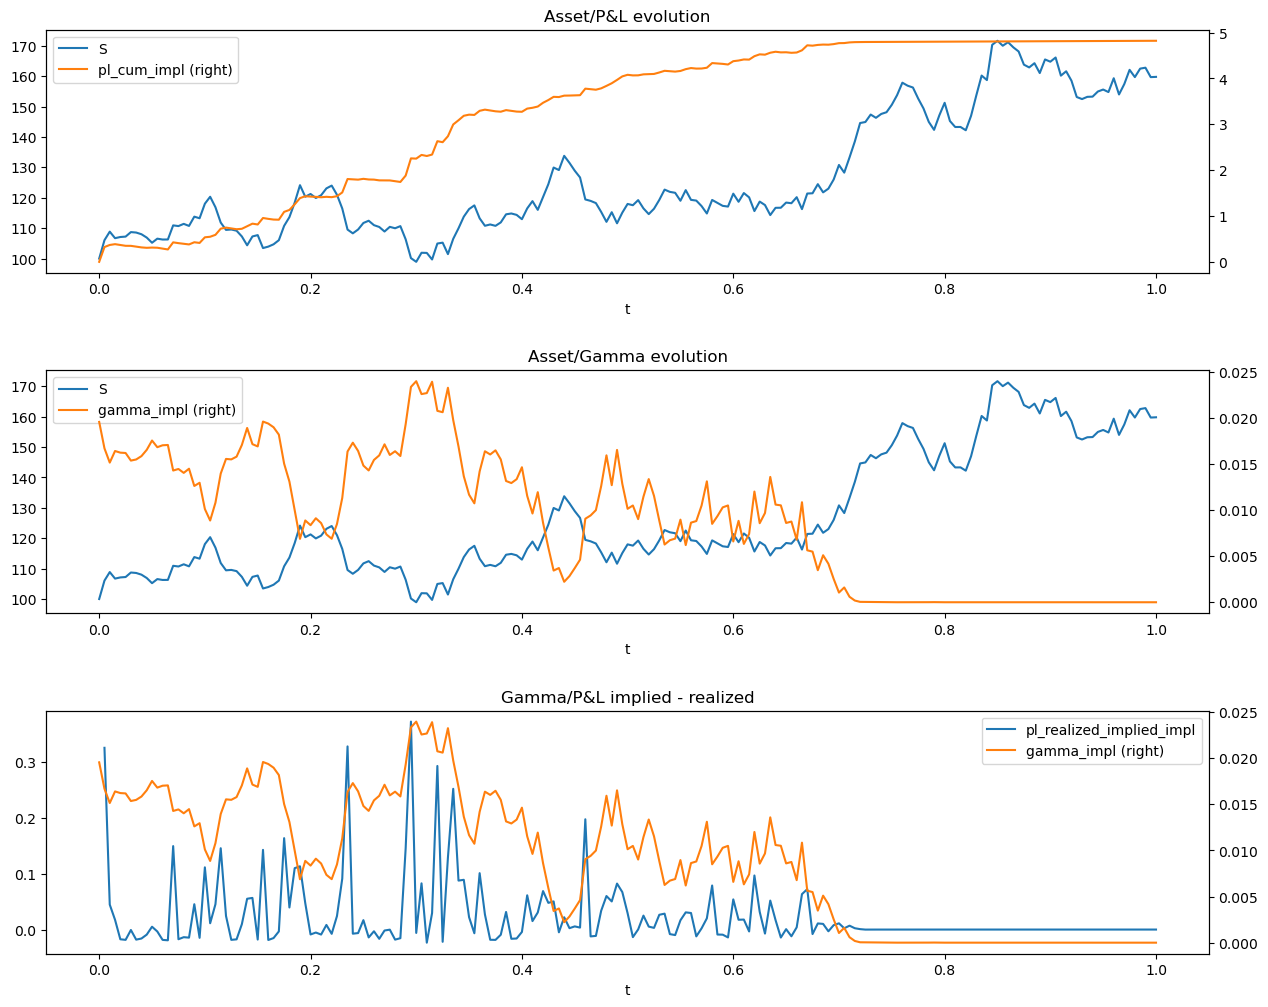

In [203]:
plot_portfolio('impl')

The Gamma P&L can be obtained by:

$$
\frac{1}{2} \Gamma S^2 \left( r_t^2 - \sigma_t^2 \Delta_t \right)
$$

and because of that, the P&L is positive when gamma is positive and $r_t^2 > \sigma_t^2 \Delta_t$ the asset return is greater than squared implied volatility in the time $dt$

The total Gamma P&L for simulation above

In [264]:
[portfolio['gamma_total_pl_local'].sum(), portfolio['gamma_total_pl_impl'].sum()]

[0.43666212185213105, 6.1911410385572445]

In this arbitrage scenario, if delta hedge is done using the local volatility, profit value is garanteed and is exactly the difference in Black Scholes Merton prices of an option using local volatility and implied volatility:

$$
V(S, t, \sigma_{local}) - V(S, t, \sigma_{impl})
$$

Let's demonstrate it reintroducing the model

$$
dS = r S dt + \sigma_{local} S dX
$$

and set up a portfolio where we buy a call option and sell $\Delta_{local}$ of the underlying, so in time $t_0 = 0$ we have the following:


|Asset|Value|
|------|-----|
|Option|$V_{impl}$|
|Stock|$-\Delta_{local} S$|
|Cash|$-V_{impl}+\Delta_{local} S$|

and when advance $dt$ in time, the portfolio becomes:

|Asset|Value|
|------|-----|
|Option|$V_{impl} + dV_{impl}$|
|Stock|$-\Delta_{local} S -\Delta_{local}\Delta S$|
|Cash|$(-V_{impl}+\Delta_{local} S)(1+r dt)$|


Therefore, the result we made mark to market is:

$$
dV_{impl} - \Delta_{local}dS -r(V_{impl} - \Delta_{local} S)dt
$$

and because the option would be correctly valued at $V_{local}$, then we have:

$$
dV_{local} - \Delta_{local}dS -r(V_{local} - \Delta_{local} S)dt
$$

Thus, the mark to market profit over $dt$ time step is:

$$
dV_{impl} - dV_{local} + r(V_{local} - \Delta_{local} S)dt -r(V_{impl} - \Delta_{local} S)dt = \\
$$
$$
dV_{impl} - dV_{local} - r(V_{impl} - V_{local})dt = \\
$$
$$
e^{rt} d \left( e^{-rt} ( V_{impl} - V_{local} ) \right)
$$

This is the profit from time $t_0$ to $t_0+dt$, the total profit from $t_0$ to expiration $T$ in the present value is:

$$
e^{rt_0} \int_{t_0}^{T} d \left( e^{-rt} ( V_{impl} - V_{local} ) \right) = ( V_{local}-V_{impl} )
$$

Therefore, in this scenario, the total portfolio profit is exactly the difference of call price calculated with $\sigma_{local}$ and $\sigma_{impl}$.

Below we will simulate the portfolio P&L many times to see that the total portfolio p&l simulated approximates to the theoretical value.

Text(0, 0.5, 'paths simulated')

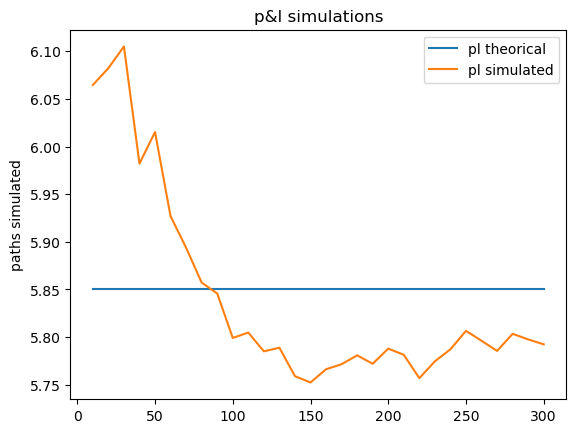

In [259]:
# calculate the theoretical portfolio p&l
pl_theo = get_call(S0, sigma_local, 0, r, K, T) - get_call(S0, sigma_impl, 0, r, K, T)

simulations = 300
result = []
pl_sum = 0
for i in range(simulations):
    pl_sum = pl_sum + get_portfolio(S0, r, K, T, N, np.random.randn(N), sigma_local, sigma_impl).loc[0].actual_pl_local
    if (i+1) % 10 == 0:
        result.append([i+1, pl_theo, pl_sum/(i+1)])

pl_study = pd.DataFrame(data=np.array(result)[:,1:], columns=['pl theorical', 'pl simulated'], index=np.array(result)[:,0])
ax = pl_study.plot(title='p&l simulations')
ax.set_ylabel('p&l')
ax.set_ylabel('paths simulated')

on the other hand, when delta hedging the porfolio using $\sigma_{implied}$, the profit is uncertain however it delivers an increase P&L along the path

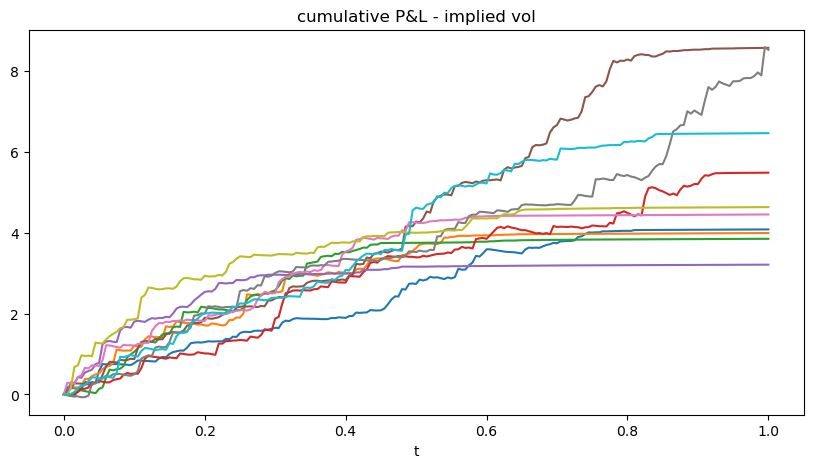

In [260]:
S0 = 100
r = 0.02
K = 100
T = 1
N = 200
vol_local = 0.35
vol_impl = 0.20

fig, ax = plt.subplots(figsize=(10,5))
for i in range(10):
    B = np.random.randn(N)
    portfolio = get_portfolio(S0, r, K, T, N, B, vol_local, vol_impl)
    portfolio.plot(x = 't', y = 'pl_cum_impl', ax = ax, legend=False)
    ax.set_title('cumulative P&L - implied vol')

## <a id='toc1_5_'></a>[Minimum Variance Delta](#toc0_)

Minimum variance takes in account expected variantions in the $\sigma_{impl}$ with respect to changes in $S$ and is defined as:

$$
\Delta_{MV} = \Delta_{BS} + \text{Vega}_{BS} \frac{\partial{E(\sigma_{impl})}}{\partial S}
$$

where 

$$
\text{Vega}_{BS} = \frac{\partial{V}}{\partial \sigma} = S\sqrt{T}N^{'}(d_1)
$$

and we will developing the estimation using a quadratic fitting,

$$
\frac{\partial{E(\sigma_{impl})}}{\partial S} \approx \frac{a + b\delta_{BS} + c\delta_{BS}^2}{S\sqrt{T}}
$$


For this excercise we will use the historical data of a MSFT call option obtained from Bloomberg 

#### <a id='toc1_5_1_1_'></a>[Load option data](#toc0_)

In [275]:
df_opt = pd.read_csv('data.csv', parse_dates=['ref_date', 'expiry'])
df_opt.head()

,ref_date,option_price,sigma_impl,asset_price,option_ticker,ticker,K,expiry,r,t
0,2023-05-01,11.62,23.619,304.8936,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.302778
1,2023-05-02,11.87,24.451,304.7439,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.300000
2,2023-05-03,11.37,24.593,303.7361,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.297222
3,2023-05-04,12.74,25.510,304.7439,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.294444
4,2023-05-05,14.10,24.573,309.9725,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.291667


In [276]:
df_opt['call_option'] = df_opt.apply(lambda row: get_call(row.asset_price, row.sigma_impl/100.0, 0, row.r, row.K, row.t), axis=1)
df_opt['D_call_option'] = df_opt.call_option - df_opt.call_option.shift(1)
df_opt['D_sigma_impl'] = df_opt.sigma_impl - df_opt.sigma_impl.shift(1)
df_opt['sqrt_t'] = np.sqrt(df_opt.t)
df_opt['D_S'] = df_opt.asset_price - df_opt.asset_price.shift(1)
df_opt['delta_bs'] = df_opt.apply(lambda row: get_delta(row.asset_price, row.sigma_impl/100.0, 0, row.r, row.K, row.t), axis=1)
df_opt['vega_bs'] = df_opt.apply(lambda row: get_vega(row.asset_price, row.sigma_impl/100.0, 0, row.r, row.K, row.t), axis=1)
df_opt['y_serie'] = df_opt.apply(lambda row: (row.sqrt_t * row.asset_price*(row.D_call_option - row.delta_bs*row.D_S))/(row.vega_bs*row.D_S), axis=1)
df_opt = df_opt.dropna().copy()
df_opt

,ref_date,option_price,sigma_impl,asset_price,option_ticker,ticker,K,expiry,r,t,call_option,D_call_option,D_sigma_impl,sqrt_t,D_S,delta_bs,vega_bs,y_serie
1,2023-05-02,11.87,24.451,304.7439,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.300000,10.797242,0.400040,0.832,0.547723,-0.1497,0.400138,64.492220,-7.951844
2,2023-05-03,11.37,24.593,303.7361,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.297222,10.410576,-0.386666,0.142,0.545181,-1.0078,0.390633,63.563065,-0.018129
3,2023-05-04,12.74,25.510,304.7439,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.294444,11.315561,0.904985,0.917,0.542627,1.0078,0.404723,64.079617,1.272890
4,2023-05-05,14.10,24.573,309.9725,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.291667,12.849303,1.533743,-0.937,0.540062,5.2286,0.448444,66.226193,-0.392074
5,2023-05-08,12.30,24.128,307.9768,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.283333,11.436700,-1.412603,-0.445,0.532291,-1.9957,0.424713,64.231829,0.722556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2023-08-09,6.54,25.227,322.2300,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.025000,6.391898,-2.400014,1.554,0.158114,-3.8200,0.581832,19.896601,0.118927
70,2023-08-10,6.35,24.182,322.9300,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.022222,6.319414,-0.072484,-1.045,0.149071,0.7000,0.611487,18.450025,-1.865662
71,2023-08-11,4.28,22.325,321.0100,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.019444,4.572447,-1.746967,-1.857,0.139443,-1.9200,0.551434,17.709116,0.906028
72,2023-08-14,5.50,20.097,324.0400,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.011111,5.256464,0.684017,-2.228,0.105409,3.0300,0.730167,11.290306,-1.526028


now, we will fit the constants a, b and c using a rolling window of 20 days

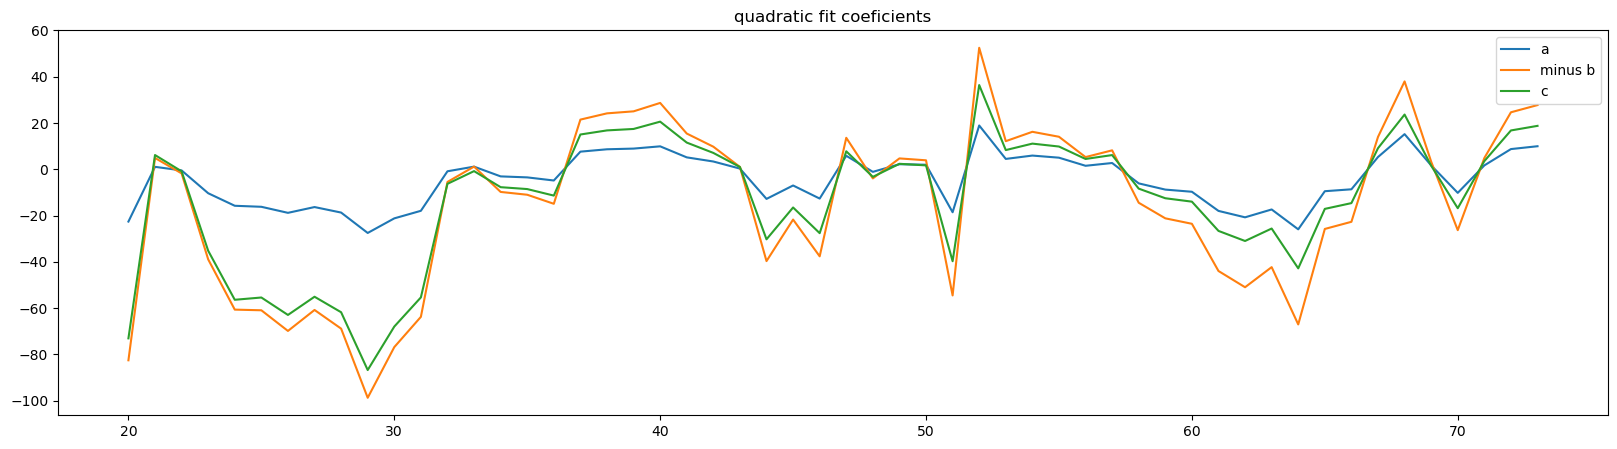

In [277]:
df_opt['a'] = float('nan')
df_opt['b'] = float('nan')
df_opt['c'] = float('nan')
r_win = 20
for i in range(r_win, len(df_opt.index)+1):
    x = df_opt.iloc[i-r_win:i].delta_bs.values
    y = df_opt.iloc[i-r_win:i].y_serie.values
    model = np.poly1d(np.polyfit(x, y, 2))
    coefs = np.poly1d(model)
    df_opt.loc[i, 'a'] = coefs[0]
    df_opt.loc[i, 'b'] = coefs[1]
    df_opt.loc[i, 'c'] = coefs[2]    

df_opt['minus b'] = -df_opt['b']
df_opt[['a','minus b','c']].plot(figsize=(20,5), title='quadratic fit coeficients');

In [281]:
df_opt['delta_mv'] = df_opt.apply(lambda x: x.delta_bs + (x.vega_bs * (x.a + x.b*x.delta_bs + x.c*x.delta_bs**2))/(x.asset_price*x.sqrt_t), axis=1)
df_opt = df_opt.dropna().copy()
df_opt

,ref_date,option_price,sigma_impl,asset_price,option_ticker,ticker,K,expiry,r,t,...,sqrt_t,D_S,delta_bs,vega_bs,y_serie,a,b,c,minus b,delta_mv
20,2023-05-30,24.30,26.889,331.21,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.222222,...,0.471405,-1.68,0.644338,58.165739,0.838083,-22.575342,82.502607,-73.033352,-82.502607,0.742264
21,2023-05-31,23.86,26.123,328.39,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.219444,...,0.468449,-2.82,0.621166,58.518077,0.547979,1.070234,-4.899459,6.163581,4.899459,0.775248
22,2023-06-01,24.80,26.031,332.58,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.216667,...,0.465475,4.19,0.660775,56.673485,-0.157678,-0.481242,1.765252,-0.860728,-1.765252,0.774035
23,2023-06-02,26.80,25.060,335.40,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.213889,...,0.462481,2.82,0.691608,54.599753,-0.692522,-10.333946,38.901086,-35.185892,-38.901086,0.600155
24,2023-06-05,27.60,24.934,335.94,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.205556,...,0.453382,0.54,0.699480,52.998314,-1.979224,-15.751499,60.615349,-56.362046,-60.615349,0.376341
25,2023-06-06,24.65,24.302,333.68,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.202778,...,0.450309,-2.26,0.682358,53.567352,0.567445,-16.192358,60.900426,-55.381419,-60.900426,0.531649
26,2023-06-07,17.42,24.119,323.38,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.200000,...,0.447214,-10.30,0.574729,56.679822,0.191524,-18.805346,69.823952,-62.913185,-69.823952,0.787713
27,2023-06-08,18.25,23.681,325.26,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.197222,...,0.444097,1.88,0.596818,55.920589,-0.510165,-16.307624,60.762899,-55.050477,-60.762899,0.731636
28,2023-06-09,19.10,24.502,326.79,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.194444,...,0.440959,1.53,0.611929,55.210158,0.579800,-18.686465,68.826430,-61.746698,-68.826430,0.730292
29,2023-06-12,23.05,24.767,331.85,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.186111,...,0.431406,5.06,0.665886,52.101710,-0.170943,-27.497903,98.698640,-86.715503,-98.698640,0.583681


And recomputing the portfolio using minimum variance delta

In [282]:
df_opt['dt'] = df_opt.t.shift(1) - df_opt.t
df_opt['portfolio_bs'] = df_opt.call_option - df_opt.delta_bs*df_opt.asset_price
df_opt['cashflow_delta_bs'] = (df_opt.delta_bs - df_opt.delta_bs.shift(1)) * df_opt.asset_price
df_opt['cash_account_bs'] = list(accumulate(df_opt[['r', 'dt', 'cashflow_delta_bs']].values[1:], lambda a,b: a * np.exp(b[0]*b[1]) + b[2], initial=-df_opt.portfolio_bs.values[0]))
df_opt['pl_cumulative_bs'] = df_opt.portfolio_bs + df_opt.cash_account_bs

df_opt['portfolio_mv'] = df_opt.call_option - df_opt.delta_mv*df_opt.asset_price
df_opt['cashflow_delta_mv'] = (df_opt.delta_mv - df_opt.delta_mv.shift(1)) * df_opt.asset_price
df_opt['cash_account_mv'] = list(accumulate(df_opt[['r', 'dt', 'cashflow_delta_mv']].values[1:], lambda a,b: a * np.exp(b[0]*b[1]) + b[2], initial=-df_opt.portfolio_mv.values[0]))
df_opt['pl_cumulative_mv'] = df_opt.portfolio_mv + df_opt.cash_account_mv

df_opt

,ref_date,option_price,sigma_impl,asset_price,option_ticker,ticker,K,expiry,r,t,...,delta_mv,dt,portfolio_bs,cashflow_delta_bs,cash_account_bs,pl_cumulative_bs,portfolio_mv,cashflow_delta_mv,cash_account_mv,pl_cumulative_mv
20,2023-05-30,24.30,26.889,331.21,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.222222,...,0.742264,NaN,-189.913122,NaN,189.913122,0.000000,-222.347131,NaN,222.347131,0.000000
21,2023-05-31,23.86,26.123,328.39,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.219444,...,0.775248,0.002778,-182.826089,-7.609516,182.314156,-0.511932,-233.425154,10.831691,233.191175,-0.233980
22,2023-06-01,24.80,26.031,332.58,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.216667,...,0.774035,0.002778,-196.075238,13.173248,195.497533,-0.577705,-233.743366,-0.403295,232.800835,-0.942530
23,2023-06-02,26.80,25.060,335.40,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.213889,...,0.600155,0.002778,-207.017087,10.341387,205.849781,-1.167305,-176.343660,-58.319562,174.494207,-1.849452
24,2023-06-05,27.60,24.934,335.94,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.205556,...,0.376341,0.008333,-210.029146,2.644412,208.528504,-1.500642,-101.473805,-75.188118,99.335174,-2.138631
25,2023-06-06,24.65,24.302,333.68,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.202778,...,0.531649,0.002778,-204.734579,-5.713058,202.827032,-1.907547,-154.446029,51.823439,151.164132,-3.281897
26,2023-06-07,17.42,24.119,323.38,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.200000,...,0.787713,0.002778,-169.593996,-34.805145,168.033155,-1.560841,-238.468863,82.805970,233.978500,-4.490363
27,2023-06-08,18.25,23.681,325.26,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.197222,...,0.731636,0.002778,-177.108385,7.184609,175.227100,-1.881285,-220.959299,-18.239753,215.751746,-5.207553
28,2023-06-09,19.10,24.502,326.79,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.194444,...,0.730292,0.002778,-181.683733,4.938347,180.175182,-1.508552,-220.363336,-0.439236,215.324496,-5.038840
29,2023-06-12,23.05,24.767,331.85,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.186111,...,0.583681,0.008333,-199.631012,17.905505,198.110718,-1.520294,-172.351346,-48.652676,166.707710,-5.643636


## <a id='toc1_6_'></a>[Local Volatility vs Implied Volatility](#toc0_)

The implied volatility surface can be transformed into a local volatility surface, which is know as the calibration of the local volatility model of Dupire. Observed options prices udner the assumption that they can be interpolated across continuous strikes and maturity using:

$$
\sigma_{local}(K,T) =\sqrt{\frac{\frac{\partial{C}}{\partial{T}}}{\frac{1}{2}K^2\frac{\partial{C}^2}{\partial{K^2}}}}
$$

For the exercise we will use finite differences to approximate the derivate as follow:

$$
\frac{\partial{C}}{\partial{T}} \approx \frac{C(K,T+\Delta T) - C(K, T-\Delta T)}{2 \Delta t}
$$

$$
\frac{\partial{C}^2}{\partial{K^2}} \approx \frac{C(K-\Delta K, T) - 2C(K,T) + C(K+\Delta K, T)}{(\Delta K)^2}
$$

For the exercise we will load data from an implied volatility surface in a grid format, where each line represents one strike and each column represents an expiry

In [287]:
S = 15.7
r = 0.01
df_vol_impl = pd.read_csv(r'vol_impl.csv')
df_vol_impl

,strike,0.08,0.17,0.25,0.33,0.42,0.5,1,2,3
0,15.70,0.322,0.293,0.291,0.295,0.297,0.298,0.299,0.306,0.3062
1,16.49,0.320,0.291,0.289,0.293,0.294,0.294,0.296,0.306,0.3063
2,17.27,0.336,0.293,0.290,0.293,0.293,0.293,0.293,0.306,0.3059
3,18.06,0.350,0.297,0.294,0.295,0.294,0.293,0.293,0.305,0.3046
4,18.84,0.350,0.307,0.302,0.299,0.297,0.295,0.292,0.303,0.3034
5,19.63,0.350,0.310,0.305,0.302,0.299,0.297,0.291,0.302,0.3022
6,20.41,0.350,0.310,0.307,0.306,0.304,0.300,0.291,0.299,0.2989
7,21.20,0.350,0.310,0.309,0.312,0.310,0.304,0.291,0.294,0.2938
8,21.98,0.350,0.310,0.310,0.314,0.313,0.307,0.292,0.289,0.2888
9,22.77,0.350,0.310,0.310,0.314,0.314,0.308,0.294,0.289,0.2890


Let´s convert the loaded data to a set of matrix and vectors in order to simplify our algorithm

In [288]:
np_vol_impl = df_vol_impl.to_numpy()
vol_impl = np.array(np_vol_impl[:,1:], dtype=np.float64)
strike = np.array(np_vol_impl[:,0], dtype=np.float64)
expiry = np.array(df_vol_impl.columns.values[1:], dtype=np.float64)

And let´s define the function that do all the work of transform a implied volatility surface into a local volatility surface

In [402]:
def get_local_volatility_surface(S, r, vol_impl, strike, expiry):

    a = np.log(S/strike)
    b = (r+vol_impl**2/2)*expiry
    c = vol_impl*np.sqrt(expiry)
    d = (a + b.T).T / c

    d_expiry = np.diff(expiry)
    d_vol_expiry = np.diff(vol_impl)
    d_vol_d_expiry = d_vol_expiry / d_expiry

    d_strike = np.diff(strike)
    d_vol_strike = np.diff(vol_impl, axis=0)
    d_vol_d_strike = (d_vol_strike.T / d_strike).T

    d_2_strike = (strike[2:] - strike[:-2])**2
    d_2_vol_strike = np.diff(d_vol_strike, axis=0)
    d_2_vol_d_2_strike = (d_2_vol_strike.T / d_2_strike).T

    numerator = vol_impl[2:,1:]**2 + 2*vol_impl[2:,1:]*expiry[1:]*(d_vol_d_expiry[2:] + (r*strike[2:]*d_vol_d_strike[1:,1:].T).T)

    f = (1+((strike[2:]*d[2:,1:].T).T * d_vol_d_strike[1:,1:]) * np.sqrt(expiry[1:]))**2
    g = (vol_impl[2:,1:].T * strike[2:]**2).T * expiry[1:]
    h = d_2_vol_d_2_strike[:,1:] - d[2:,1:]*d_vol_d_strike[1:,1:]**2*np.sqrt(expiry[1:])

    denominator = f+g*h

    return  np.sqrt(numerator/denominator), strike[2:], expiry[1:]

vol_local, strike_local, expiry_local = get_local_volatility_surface(S, r, vol_impl, strike, expiry)

vol_local, strike_local, expiry_local

(array([[0.19587057, 0.2786097 , 0.30161581, 0.28709872, 0.28399353,
         0.28952619, 0.33098036, 0.31490758],
        [0.17565044, 0.29177151, 0.30101559, 0.28731969, 0.28394292,
         0.27731592, 0.34102593, 0.32147874],
        [0.23714043, 0.31233798, 0.29799317, 0.29377744, 0.28356077,
         0.28864995, 0.33428038, 0.30134906],
        [0.24198875, 0.31529815, 0.30766302, 0.29780318, 0.29411066,
         0.27445914, 0.30594824, 0.30021188],
        [0.22496164, 0.31294554, 0.32620219, 0.31609249, 0.28801994,
         0.26594498, 0.33344273, 0.34371739],
        [0.22193593, 0.32194745, 0.36974025, 0.34537944, 0.28748499,
         0.26372144, 0.30071909, 0.31275748],
        [0.22193593, 0.32201368, 0.36728538, 0.35350908, 0.29732356,
         0.26014778, 0.25054935, 0.25784563],
        [0.22193593, 0.31255806, 0.33752645, 0.3344793 , 0.2870245 ,
         0.27322128, 0.21988569, 0.20762951],
        [0.22193593, 0.31      , 0.33008787, 0.33183222, 0.30697897,
         0.

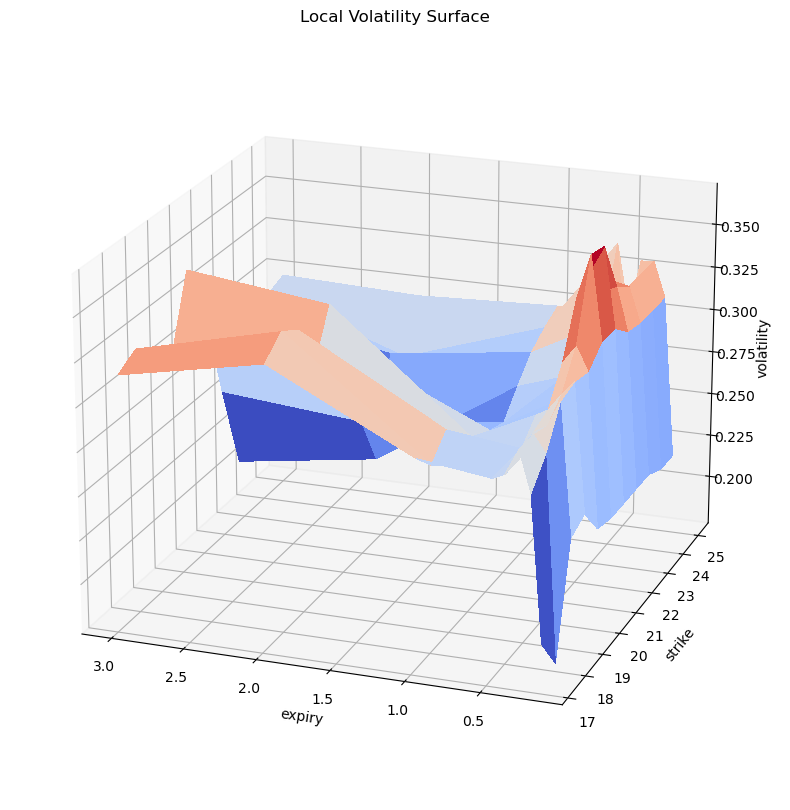

In [400]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20,10))

X, Y = np.meshgrid(expiry_local, strike_local)

# Plot the surface.
surf = ax.plot_surface(X, Y, vol_local, cmap=cm.coolwarm, linewidth=0, antialiased=False)

#ax.view_init(-160, -30)
ax.view_init(-160, 70)
ax.invert_zaxis()

plt.title('Local Volatility Surface')
ax.set_xlabel('expiry')
ax.set_ylabel('strike')
ax.set_zlabel('volatility')
plt.show()

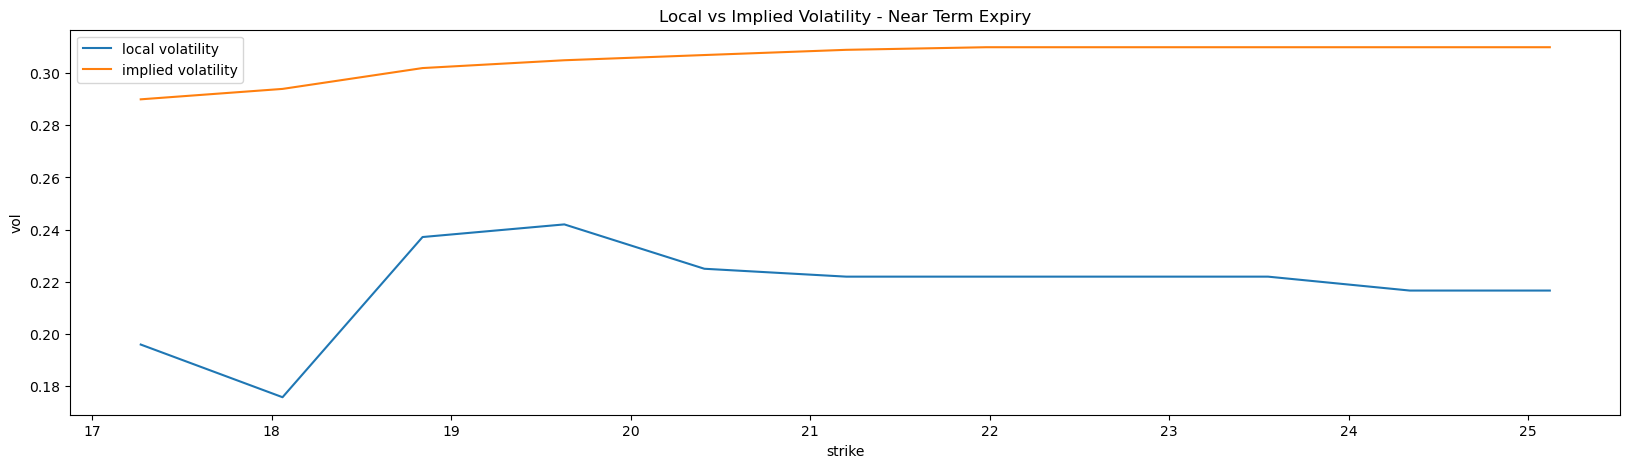

In [401]:
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(strike_local, vol_local[:,0])
ax.plot(strike[2:], vol_impl[2:,2])

plt.title('Local vs Implied Volatility - Near Term Expiry')
ax.set_xlabel('strike')
ax.set_ylabel('vol')
ax.legend(['local volatility', 'implied volatility'])

## <a id='toc1_7_'></a>[References](#toc0_)

- [Investopedia - Monte Carlo](https://www.investopedia.com/articles/07/montecarlo.asp)
- HILPISCH, Yves. **Python for Finance: Mastering Data-driven Finance**. 2. ed. O'Reilly Media, 2019.
- Galanti & Jung: "Low-Discrepancy Sequences: Monte Carlo Simulation of Option Prices", Journal of Derivatives, Fall 1997, pp.63-83.
- Glasserman, P. (2003) Monte Carlo Methods in Financial Engineering. In: Stochastic Modelling and Applied Probability, Springer-Verlag, New York.